<a href="https://colab.research.google.com/github/Blackan06/Blackan06/blob/main/wqi_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-21-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-21-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score ,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp,unix_timestamp, col
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from xgboost.spark import SparkXGBRegressor

In [3]:
# Đọc dữ liệu từ file CSV
file_path = 'https://drive.google.com/uc?id=1b-lbe9rMg1rs4BvL8vApy--w_8o4zef3&export=download'
df = pd.read_csv(file_path)


# Kiểm tra 5 dòng đầu tiên
df.head()

# Kiểm tra kiểu dữ liệu và các giá trị thiếu
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         748 non-null    object 
 1   Temperature  748 non-null    float64
 2   PH           748 non-null    float64
 3   DO           748 non-null    float64
 4   WQI          748 non-null    float64
dtypes: float64(4), object(1)
memory usage: 29.3+ KB


,0
Date,object
Temperature,float64
PH,float64
DO,float64
WQI,float64


In [4]:
df.dtypes

,0
Date,object
Temperature,float64
PH,float64
DO,float64
WQI,float64


In [5]:
df.head()

,Date,Temperature,PH,DO,WQI
0,2003-01-15,29.0,5.78,6.05,63.17
1,2003-01-15,29.0,6.89,6.21,69.94
2,2003-01-15,30.0,7.24,7.02,79.60
3,2003-02-15,28.0,6.61,6.95,69.14
4,2003-02-15,29.0,6.91,6.63,72.35


In [6]:
df.columns

Index(['Date', 'Temperature', 'PH', 'DO', 'WQI'], dtype='object')

In [7]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,748,255,2003-01-15,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,748.0,NaN,NaN,NaN,28.142126,1.383786,23.1,27.3,28.285,29.0925,33.0
PH,748.0,NaN,NaN,NaN,6.635624,0.830904,1.9,6.3,6.85,7.2,8.18
DO,748.0,NaN,NaN,NaN,6.357583,0.827614,1.9,5.88,6.355,6.9625,7.99
WQI,748.0,NaN,NaN,NaN,66.511203,7.346703,38.2,61.98,66.615,71.7725,86.12


In [8]:
df.WQI.value_counts()

,count
WQI,
61.98,4
68.16,3
65.95,3
66.01,3
67.46,3
...,...
76.43,1
60.45,1
80.71,1


In [9]:
df.nunique()

,0
Date,255
Temperature,134
PH,288
DO,283
WQI,637


In [10]:
# Kiểm tra các giá trị trong cột 'Date'
print(df['Date'].head(10))

# Chuyển cột 'Date' thành kiểu datetime trong pandas, nếu có lỗi sẽ tạo giá trị NaT
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Kiểm tra lại dữ liệu sau khi chuyển đổi
print(df['Date'].head(10))

# Kiểm tra các giá trị NaT (nếu có)
print(df[df['Date'].isna()])


0    2003-01-15
1    2003-01-15
2    2003-01-15
3    2003-02-15
4    2003-02-15
5    2003-02-15
6    2003-03-15
7    2003-03-15
8    2003-03-15
9    2003-04-15
Name: Date, dtype: object
0   2003-01-15
1   2003-01-15
2   2003-01-15
3   2003-02-15
4   2003-02-15
5   2003-02-15
6   2003-03-15
7   2003-03-15
8   2003-03-15
9   2003-04-15
Name: Date, dtype: datetime64[ns]
Empty DataFrame
Columns: [Date, Temperature, PH, DO, WQI]
Index: []


#Visualize the data


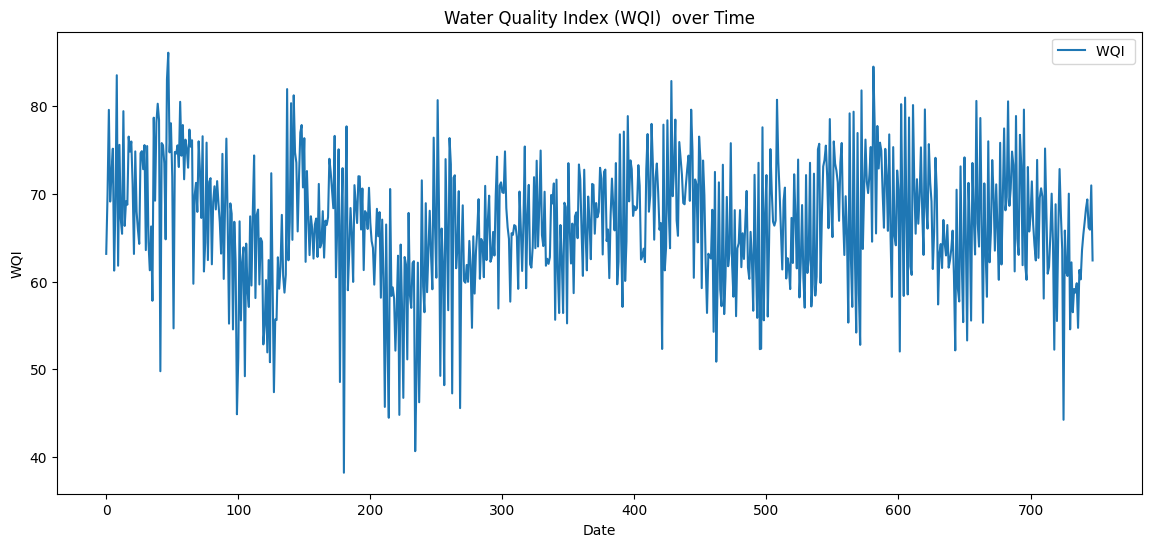

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['WQI'], label=f'WQI ')
plt.xlabel('Date')
plt.ylabel('WQI')
plt.title(f'Water Quality Index (WQI)  over Time')
plt.legend()
plt.show()

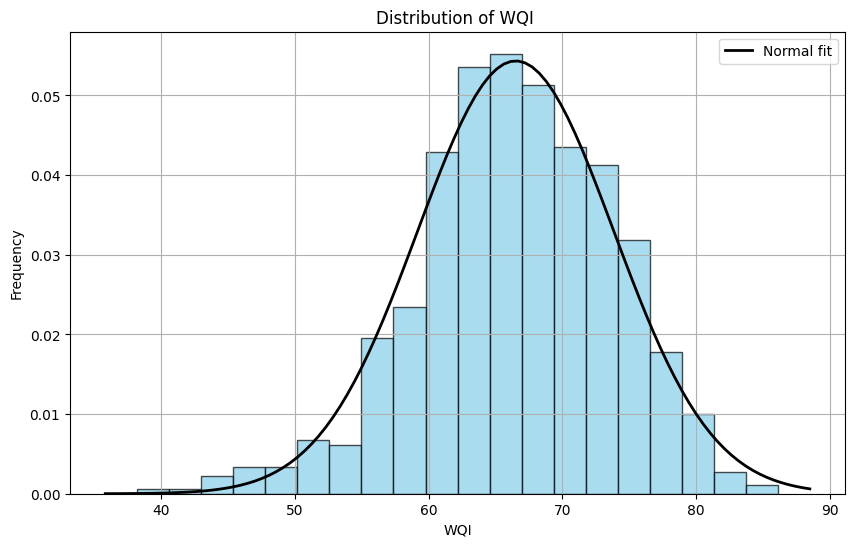

In [12]:
plt.figure(figsize=(10, 6))

# Vẽ histogram
plt.hist(df['WQI'], bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.7)

# Thêm đường phân phối chuẩn
mu, std = stats.norm.fit(df['WQI'])  # Ước tính các tham số của phân phối chuẩn (mean, std)
xmin, xmax = plt.xlim()  # Lấy phạm vi của trục x
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)  # Tính giá trị của hàm mật độ xác suất (PDF) cho phân phối chuẩn
plt.plot(x, p, 'k', linewidth=2, label='Normal fit')  # Vẽ đường chuẩn

# Thêm nhãn và tiêu đề
plt.title(f'Distribution of WQI ')
plt.xlabel('WQI')
plt.ylabel('Frequency')

# Hiển thị lưới và chú giải
plt.grid(True)
plt.legend()

# Hiển thị đồ thị
plt.show()

In [13]:
# Kiểm tra tính ổn định (stationarity) của WQI cho từng khu vực
result = adfuller(df['WQI'].dropna())  # Loại bỏ giá trị thiếu nếu có
print(f"ADF Statistic for  {result[0]}")
print(f"p-value for  {result[1]}")

if result[1] < 0.05:
    print(f"Chuỗi thời gian là ổn định.")
else:
    print(f"Chuỗi thời gian  không ổn định, cần thực hiện differencing.")
print("\n")


ADF Statistic for  -5.492913666943551
p-value for  2.1551391498623015e-06
Chuỗi thời gian là ổn định.




## Handle missing values

In [14]:
df.isnull().sum()

,0
Date,0
Temperature,0
PH,0
DO,0
WQI,0


#Check trend or seasonality

<Figure size 1400x600 with 0 Axes>

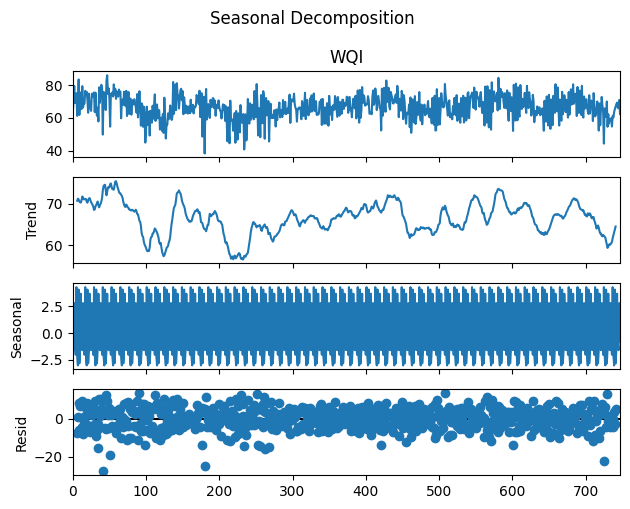

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Thực hiện phân tích mùa vụ cho cột 'WQI'
result = seasonal_decompose(df['WQI'], model='additive', period=12)

# Đặt kích thước cho hình vẽ trước khi plot
plt.figure(figsize=(14, 6))

# Vẽ đồ thị phân tích mùa vụ
result.plot()

# Đặt tiêu đề cho biểu đồ
plt.suptitle(f"Seasonal Decomposition \n", y=1.05)

# Hiển thị đồ thị
plt.show()


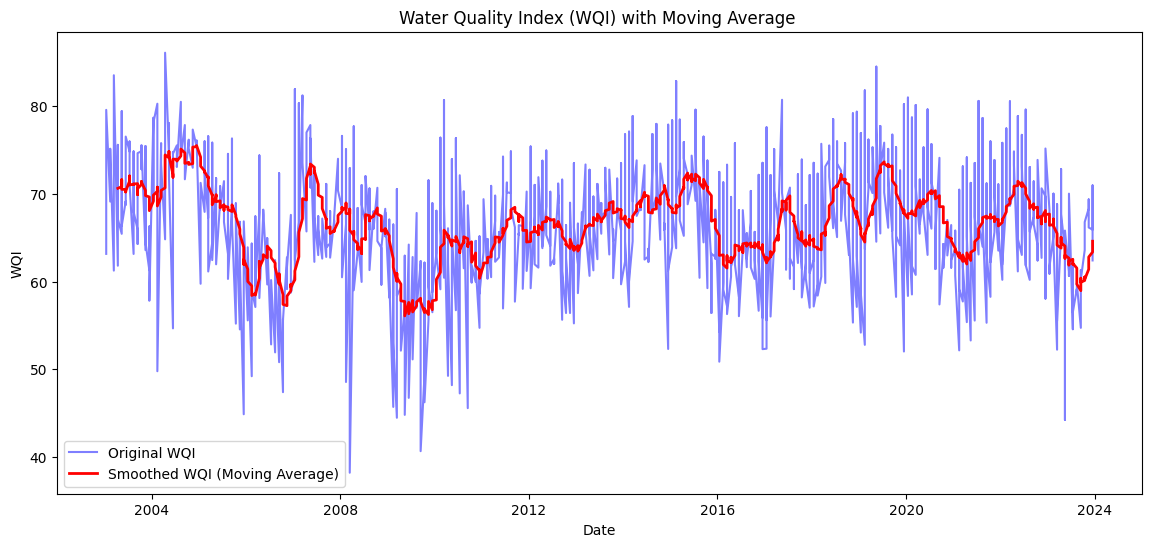

In [16]:
# Tính Moving Average (chu kỳ 12 tháng) cho từng khu vực

# Tính Moving Average cho WQI
df['WQI_MA'] = df['WQI'].rolling(window=12).mean()

# Vẽ biểu đồ WQI gốc và WQI sau khi làm mượt cho từng khu vực
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['WQI'], label='Original WQI', color='blue', alpha=0.5)
plt.plot(df['Date'], df['WQI_MA'], label='Smoothed WQI (Moving Average)', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('WQI')
plt.title(f'Water Quality Index (WQI) with Moving Average ')
plt.legend()
plt.show()


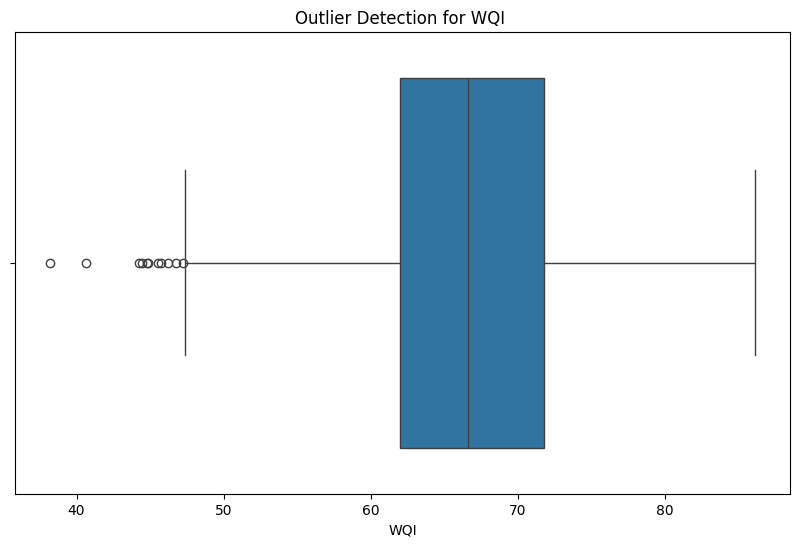

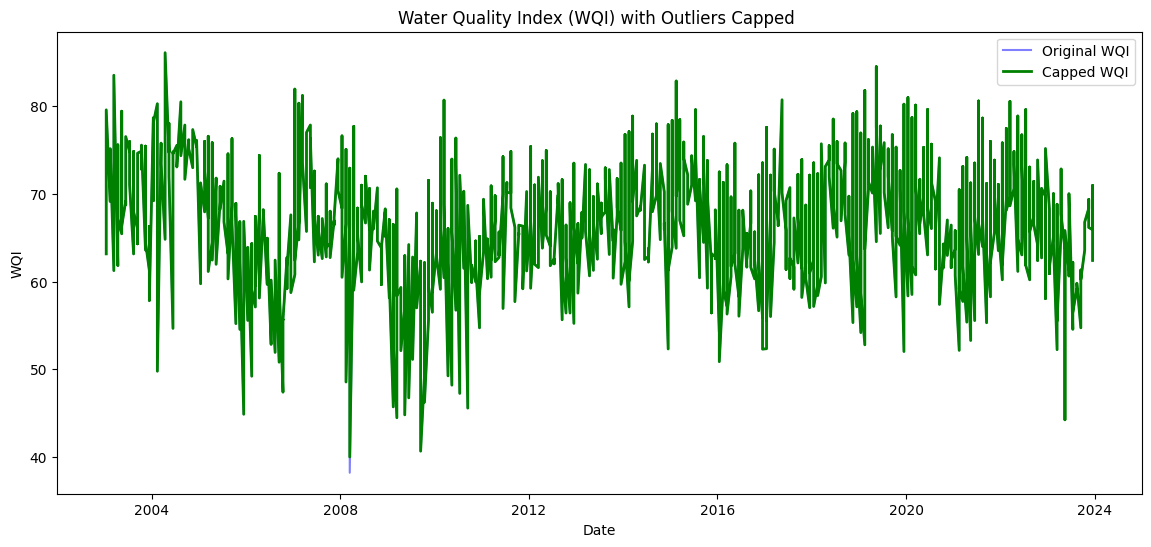

In [17]:


plt.figure(figsize=(10, 6))
sns.boxplot(x=df['WQI'])
plt.title(f'Outlier Detection for WQI ')
plt.show()

# Capping ngoại lai: Giới hạn WQI trong phạm vi hợp lý (ví dụ: từ 40 đến 90)
df['WQI_capped'] = df['WQI'].clip(lower=40, upper=90)

# Vẽ lại dữ liệu sau khi capping
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['WQI'], label='Original WQI', color='blue', alpha=0.5)
plt.plot(df['Date'], df['WQI_capped'], label='Capped WQI', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('WQI')
plt.title(f'Water Quality Index (WQI) with Outliers Capped ')
plt.legend()
plt.show()


#SPARK CONTEXT

In [18]:
import findspark
findspark.init()

In [19]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [20]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("WQI_Prediction").config("spark.driver.memory", "2g").config("spark.executor.memory", "2g").getOrCreate()

# Define schema - explicitly cast all columns to desired types, use TimestampType for Date
mySchema = StructType([
    StructField("Date", TimestampType(), True),  # Changed to TimestampType
    StructField("DO", FloatType(), True),
    StructField("PH", FloatType(), True),
    StructField("Temperature", FloatType(), True),
    StructField("WQI", FloatType(), True)
])

# Convert pandas DataFrame to Spark DataFrame using the schema
# Convert 'Date' column to native Python datetime objects before creating the Spark DataFrame
df_spark = spark.createDataFrame(df, schema=mySchema)
# Verify schema and data
df_spark.printSchema()
df_spark.show(5)

df_spark = df_spark.withColumn("Date", unix_timestamp("Date", "yyyy-MM-dd").cast("timestamp"))
df_spark.printSchema()
df_spark.show(5)

root
 |-- Date: timestamp (nullable = true)
 |-- DO: float (nullable = true)
 |-- PH: float (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- WQI: float (nullable = true)

+-------------------+----+----+-----------+-----+
|               Date|  DO|  PH|Temperature|  WQI|
+-------------------+----+----+-----------+-----+
|2003-01-15 00:00:00|29.0|5.78|       6.05|63.17|
|2003-01-15 00:00:00|29.0|6.89|       6.21|69.94|
|2003-01-15 00:00:00|30.0|7.24|       7.02| 79.6|
|2003-02-15 00:00:00|28.0|6.61|       6.95|69.14|
|2003-02-15 00:00:00|29.0|6.91|       6.63|72.35|
+-------------------+----+----+-----------+-----+
only showing top 5 rows

root
 |-- Date: timestamp (nullable = true)
 |-- DO: float (nullable = true)
 |-- PH: float (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- WQI: float (nullable = true)

+-------------------+----+----+-----------+-----+
|               Date|  DO|  PH|Temperature|  WQI|
+-------------------+----+----+-----------+-----+
|

#Classification

In [21]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80% huấn luyện, 20% kiểm tra)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=1234)

# Kiểm tra kích thước của các tập
print(f"Training Data: {train_data.count()} rows")
print(f"Test Data: {test_data.count()} rows")


Training Data: 598 rows
Test Data: 150 rows


In [22]:
# Tạo vector đặc trưng cho mô hình
vectorAssembler = VectorAssembler(inputCols=["Temperature", "PH", "DO"], outputCol="features")

# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="WQI", predictionCol="prediction")

# Tạo pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

# Huấn luyện mô hình
model = pipeline.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions = model.transform(test_data)

# Hiển thị kết quả dự đoán
predictions.select("Date", "WQI", "prediction").show(5)


+-------------------+-----+-----------------+
|               Date|  WQI|       prediction|
+-------------------+-----+-----------------+
|2003-01-15 00:00:00|69.94|69.34764298721834|
|2003-02-15 00:00:00|72.35|72.93050884069665|
|2003-08-15 00:00:00|74.86|72.53613761304565|
|2003-09-15 00:00:00|64.31| 63.0121163833777|
|2003-09-15 00:00:00|74.66|71.76683904012289|
+-------------------+-----+-----------------+
only showing top 5 rows



In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

# Đánh giá mô hình
evaluator = RegressionEvaluator(labelCol="WQI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

# Tính R^2
r2_evaluator = RegressionEvaluator(labelCol="WQI", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R^2 on test data: {r2}")


Root Mean Squared Error (RMSE) on test data: 3.766144902265591
R^2 on test data: 0.7738592479555297


In [ ]:
# Update ParamGridBuilder to include more hyperparameters
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 300])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.maxBins, [32, 64])
             .addGrid(rf.minInstancesPerNode, [1, 2, 4])
             .addGrid(rf.subsamplingRate, [0.8, 0.9, 1.0])
             .build())

# Tạo lại CrossValidator với hyperparameter mới
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Sử dụng 5 lần cross-validation

# Huấn luyện mô hình với Cross-Validation
cv_model = crossval.fit(train_data)

# Dự đoán trên tập kiểm tra
cv_predictions = cv_model.transform(test_data)

# Hiển thị kết quả dự đoán với model đã được tối ưu hóa
cv_predictions.select("Date", "WQI", "prediction").show(5)

# Đánh giá mô hình tối ưu hóa
cv_rmse = evaluator.evaluate(cv_predictions)
print(f"Root Mean Squared Error (RMSE) on test data (with tuned model): {cv_rmse}")

# Tính R^2 của mô hình tối ưu hóa
cv_r2 = r2_evaluator.evaluate(cv_predictions)
print(f"R^2 on test data (with tuned model): {cv_r2}")


In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])  # Số cây trong Random Forest
             .addGrid(rf.maxDepth, [5, 10, 15])    # Độ sâu tối đa của cây
             .addGrid(rf.maxBins, [32, 64])         # Số lượng phân vùng cho các đặc trưng
             .build())

# Tạo CrossValidator với Metric RMSE
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Sử dụng 5 lần cross-validation

# Huấn luyện mô hình với Cross-Validation
cv_model = crossval.fit(train_data)

# Dự đoán trên tập kiểm tra
cv_predictions = cv_model.transform(test_data)

# Hiển thị kết quả dự đoán với model đã được tối ưu hóa
cv_predictions.select("Date", "WQI", "prediction").show(5)

# Đánh giá mô hình tối ưu hóa
cv_rmse = evaluator.evaluate(cv_predictions)
print(f"Root Mean Squared Error (RMSE) on test data (with tuned model): {cv_rmse}")

# Tính R^2 của mô hình tối ưu hóa
cv_r2 = r2_evaluator.evaluate(cv_predictions)
print(f"R^2 on test data (with tuned model): {cv_r2}")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Khai báo mô hình XGBoost cho bài toán hồi quy
xgb = SparkXGBRegressor(featuresCol="scaledFeatures",
                        labelCol="WQI",
                        predictionCol="prediction")

# Xây dựng pipeline gồm các bước: vectorAssembler -> scaler -> xgb
pipeline_xgb = Pipeline(stages=[vectorAssembler, scaler, xgb])

# Xây dựng lưới tham số cho XGBoost
paramGrid = (ParamGridBuilder()
             .addGrid(xgb.max_depth, [5, 10, 15, 20])
             .addGrid(xgb.eta, [0.01, 0.1, 0.3])
             .addGrid(xgb.numRound, [100, 200, 300])
             .addGrid(xgb.subsample, [0.8, 0.9, 1.0])
             .addGrid(xgb.colsample_bytree, [0.8, 0.9, 1.0])
             .build())

# Định nghĩa evaluator, bạn có thể sử dụng metric "rmse" hoặc "r2" (ở đây ta sử dụng R^2 để so sánh với RF đạt 0.88)
evaluator = RegressionEvaluator(labelCol="WQI", predictionCol="prediction", metricName="r2")

# Thiết lập CrossValidator với 5-fold cross validation
crossval = CrossValidator(estimator=pipeline_xgb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Huấn luyện mô hình XGBoost trên tập huấn luyện
cv_model_xgb = crossval.fit(train_data)

# Dự đoán trên tập kiểm tra với mô hình XGBoost tối ưu
xgb_predictions = cv_model_xgb.transform(test_data)

# Hiển thị một vài dự đoán: cột "Date", giá trị thật của "WQI" và "prediction"
xgb_predictions.select("Date", "WQI", "prediction").show(5)

# Đánh giá mô hình XGBoost: tính R^2
xgb_r2 = evaluator.evaluate(xgb_predictions)
print(f"XGBoost Model R^2 on test data: {xgb_r2:.2f}")

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 300])
             .addGrid(rf.maxDepth, [5, 10, 15, 20])
             .addGrid(rf.maxBins, [32, 64, 128])
             .addGrid(rf.minInstancesPerNode, [1, 2, 4, 6])
             .addGrid(rf.subsamplingRate, [0.7, 0.8, 0.9, 1.0])
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)

cv_predictions = cv_model.transform(test_data)

cv_predictions.select("Date", "WQI", "prediction").show(3)

cv_rmse = evaluator.evaluate(cv_predictions)
print(f"Root Mean Squared Error (RMSE) on test data (with tuned model): {cv_rmse}")

cv_r2 = r2_evaluator.evaluate(cv_predictions)
print(f"R^2 on test data (with tuned model): {cv_r2}")
